<a href="https://colab.research.google.com/github/TimH2024/MSC-M5-Project/blob/main/6_Std_dataset_LTSM_Timestamp%2C_ensemble_and_bidireectional_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Timestamp and Ensemble

# LOAD LIBRARIES

In [1]:
pip install tensorflow keras keras-tuner numpy pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [2]:
# Core libraries
import numpy as np
import pandas as pd

from google.colab import drive

import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tabulate import tabulate
import datetime

# Keras Tuner for hyperparameter tuning
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

# LOAD FILES

In [3]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Std_Datasetv6.csv'

# Read the file into a DataFrame
try:
    merged_dataset = pd.read_csv(file_path)
    print("[INFO] File loaded successfully into 'merged_dataset'.")
    print(merged_dataset.head())  # Display the first 5 rows
except FileNotFoundError:
    print(f"[ERROR] File not found at '{file_path}'. Please check the file path and try again.")
except Exception as e:
    print(f"[ERROR] An error occurred while reading the file: {e}")

Mounted at /content/drive
[INFO] File loaded successfully into 'merged_dataset'.
   saleable_area(ft^2)  unit_rate  floor  CPI   PC  IR  MW  M3  SD  UR  ...  \
0                  423      15792   22.0    0  351   3  18  17   0   3  ...   
1                  761      15857   12.0    0  351   3  18  17   0   3  ...   
2                  320      13717   12.0    0  351   3  18  17   0   3  ...   
3                  519      16541   29.0    0  351   3  18  17   0   3  ...   
4                  699      14721   24.0    0  351   3  18  17   0   3  ...   

   floor_height_floor_16to18  floor_height_floor_19to20  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   floor_height_floor_21to25  floor_height_floor_26to30  \
0                          1  

In [4]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/master_resultsStd.csv'

# Read the file into a DataFrame
try:
    master_resultsStd = pd.read_csv(file_path)
    print("[INFO] File loaded successfully into 'master_resultsStd'.")
    print(master_resultsStd.head())  # Display the first 5 rows
except FileNotFoundError:
    print(f"[ERROR] File not found at '{file_path}'. Please check the file path and try again.")
except Exception as e:
    print(f"[ERROR] An error occurred while reading the file: {e}")

Mounted at /content/drive
[INFO] File loaded successfully into 'master_resultsStd'.
      Target                        Model  Train R²   Test R²       MAE  \
0  new_price            Linear Regression  0.963865  0.963759  0.138895   
1  new_price      Random Forest Regressor  0.999990  0.999926  0.004156   
2  new_price            XGBoost Regressor  0.999799  0.999632  0.010089   
3  new_price  Gradient Boosting Regressor  0.999693  0.999640  0.014378   
4         PC            Linear Regression  0.973660  0.974082  0.131777   

        MSE      RMSE       MAPE Comments                      Type  
0  0.036411  0.190816  68.357874   Normal  Simple Linear Regression  
1  0.000075  0.008643   2.233156   Normal       Decision Tree Model  
2  0.000370  0.019230   3.287954   Normal       Decision Tree Model  
3  0.000361  0.019010  10.263437   Normal       Decision Tree Model  
4  0.025915  0.160980  29.441769   Normal  Simple Linear Regression  


In [5]:
print(master_resultsStd)

       Target                        Model  Train R²   Test R²           MAE  \
0   new_price            Linear Regression  0.963865  0.963759  1.388949e-01   
1   new_price      Random Forest Regressor  0.999990  0.999926  4.155748e-03   
2   new_price            XGBoost Regressor  0.999799  0.999632  1.008896e-02   
3   new_price  Gradient Boosting Regressor  0.999693  0.999640  1.437758e-02   
4          PC            Linear Regression  0.973660  0.974082  1.317771e-01   
5          PC      Random Forest Regressor  1.000000  1.000000  1.665155e-14   
6          PC            XGBoost Regressor  0.999957  0.999957  6.098938e-03   
7          PC  Gradient Boosting Regressor  1.000000  1.000000  1.221103e-08   
8   new_price                    Base LSTM  0.996020  0.995922  1.025696e+05   
9          PC                    Base LSTM  0.998868  0.998890  5.939950e-01   
10  new_price                Enhanced LSTM  0.996919  0.996889  9.012282e+04   
11         PC                Enhanced LS

# MODEL TARGETS AND FEATURES

In [6]:
# Define the feature matrix (X) and target variables (y)

features = merged_dataset.drop(columns=['new_price', 'PC'])
targets_Std = merged_dataset[['new_price', 'PC']]

X = features.copy()
y = targets_Std.copy()

In [7]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Data columns (total 71 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   saleable_area(ft^2)                             72663 non-null  int64  
 1   unit_rate                                       72663 non-null  int64  
 2   floor                                           72663 non-null  float64
 3   CPI                                             72663 non-null  int64  
 4   PC                                              72663 non-null  int64  
 5   IR                                              72663 non-null  int64  
 6   MW                                              72663 non-null  int64  
 7   M3                                              72663 non-null  int64  
 8   SD                                              72663 non-null  int64  
 9   UR                                     

# LSTM WITH TIME STAMP
(by espressly utilising the scaled timestamp such that it is not just another feature)

In [14]:
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate

# Step 1: Restore or Create the Timestamp Column
if 'Timestamp' in merged_dataset.columns:
    # If the Timestamp column exists, convert it to datetime
    merged_dataset['Timestamp'] = pd.to_datetime(merged_dataset['Timestamp'], errors='coerce')
elif isinstance(merged_dataset.index, pd.DatetimeIndex):
    # If the index is a DatetimeIndex, convert it back to a column
    merged_dataset['Timestamp'] = merged_dataset.index
else:
    # If no Timestamp exists, create a synthetic one (e.g., sequential numbers as a fake timestamp)
    print("Warning: No Timestamp found. Creating a synthetic sequence as Timestamp.")
    merged_dataset['Timestamp'] = pd.date_range(start="2023-01-01", periods=len(merged_dataset), freq="D")

# Step 2: Sort by Timestamp
merged_dataset = merged_dataset.sort_values(by='Timestamp')

# Step 3: Create a Numeric Timestamp Feature
merged_dataset['Timestamp_numeric'] = merged_dataset['Timestamp'].astype(int) / 1e9  # Numeric conversion for scaling

# Step 4: Handle Outliers in `new_price`
q1 = merged_dataset["new_price"].quantile(0.01)
q99 = merged_dataset["new_price"].quantile(0.99)
merged_dataset["new_price"] = merged_dataset["new_price"].clip(lower=q1, upper=q99)

# Define feature matrix and targets
features = merged_dataset.drop(columns=["new_price", "PC", "Timestamp"])
features = features.select_dtypes(include=[np.number])  # Select only numeric features
timestamp_feature = merged_dataset["Timestamp_numeric"].values.reshape(-1, 1)

target_new_price = merged_dataset["new_price"]
target_PC = merged_dataset["PC"]

# Scale the data
scaler_X = MinMaxScaler()
scaled_features = scaler_X.fit_transform(features)

scaler_timestamp = MinMaxScaler()
scaled_timestamp = scaler_timestamp.fit_transform(timestamp_feature)

scaler_new_price = MinMaxScaler()
scaler_PC = MinMaxScaler()

target_new_price_scaled = scaler_new_price.fit_transform(target_new_price.values.reshape(-1, 1))
target_PC_scaled = scaler_PC.fit_transform(target_PC.values.reshape(-1, 1))

# Combine scaled features and scaled timestamp
scaled_features_with_timestamp = np.hstack((scaled_features, scaled_timestamp))

# Train-test split
X_train, X_test, y_train_new_price, y_test_new_price = train_test_split(
    scaled_features_with_timestamp, target_new_price_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train, X_val, y_train_new_price, y_val_new_price = train_test_split(
    X_train, y_train_new_price, test_size=0.2, random_state=42, shuffle=False
)

X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(
    scaled_features_with_timestamp, target_PC_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_PC, X_val_PC, y_train_PC, y_val_PC = train_test_split(
    X_train_PC, y_train_PC, test_size=0.2, random_state=42, shuffle=False
)

# Reshape data for LSTM
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

X_train_PC = np.expand_dims(X_train_PC, axis=1)
X_val_PC = np.expand_dims(X_val_PC, axis=1)
X_test_PC = np.expand_dims(X_test_PC, axis=1)

# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Train and evaluate the LSTM model
results = []

for target, (X_train_target, X_val_target, X_test_target, y_train, y_val, y_test, scaler) in {
    "new_price": (X_train, X_val, X_test, y_train_new_price, y_val_new_price, y_test_new_price, scaler_new_price),
    "PC": (X_train_PC, X_val_PC, X_test_PC, y_train_PC, y_val_PC, y_test_PC, scaler_PC),
}.items():
    print(f"Training LSTM for {target}...")
    model = build_lstm_model(input_shape=(X_train_target.shape[1], X_train_target.shape[2]))

    early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

    history = model.fit(
        X_train_target, y_train,
        validation_data=(X_val_target, y_val),
        epochs=10,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping],
    )

    y_pred_scaled = model.predict(X_test_target).flatten()
    y_test_scaled = y_test.flatten()

    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2_train = r2_score(scaler.inverse_transform(y_train), scaler.inverse_transform(model.predict(X_train_target)))
    r2_test = r2_score(y_test, y_pred)

    nonzero_indices = y_test != 0
    mape = np.mean(np.abs((y_test[nonzero_indices] - y_pred[nonzero_indices]) / y_test[nonzero_indices])) * 100 if np.any(nonzero_indices) else np.nan

    # Save results in a dictionary
    results.append({
        "Target": target,
        "Model": "LSTM with Timestamp",
        "Train R²": r2_train,
        "Test R²": r2_test,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })

# Convert results to DataFrame
new_results = pd.DataFrame(results)

# Update the master results table
for _, new_row in new_results.iterrows():
    master_resultsStd = master_resultsStd[
        ~((master_resultsStd["Target"] == new_row["Target"]) & (master_resultsStd["Model"] == new_row["Model"]))
    ]

# Append new results
master_resultsStd = pd.concat([master_resultsStd, new_results], ignore_index=True)

# Display the updated results
print("Updated Master Results Table (with Overwritten Rows for Same Model and Target):")
print(master_resultsStd.to_string(index=False))

# Visualize the results as a table
print("\nComparison of All Machine Learning Models:")
print(tabulate(master_resultsStd, headers="keys", tablefmt="pretty"))

Training LSTM for new_price...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0416 - mae: 0.1456 - val_loss: 0.0079 - val_mae: 0.0725
Epoch 2/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0066 - mae: 0.0620 - val_loss: 0.0125 - val_mae: 0.0879
Epoch 3/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0044 - mae: 0.0499 - val_loss: 0.0110 - val_mae: 0.0821
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Training LSTM for PC...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0416 - mae: 0.1330 - val_loss: 0.0015 - val_mae: 0.0263
Epoch 2/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0059 - mae: 0.0581 - val_loss: 0.0017 - val_mae: 0.0278
Epoch 3/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0047 - mae: 0.0523 - val_loss: 0.0018 - val_mae: 0.0323
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Updated Master Results Table (with Overwritten Rows for Same Model and Target):
   Target                       Model  Train R²  Test R²          MAE          MSE         RMSE         MAPE     Comments                     Type           Timestamp
new_price           Linear Regression  0.963865 0.963759 1.388949e-01 3.641067e-02 1.908158e-01 6.835787e+01       Normal Simple Linear Regression                 NaN
new_price     Random Forest Regressor  0.999990 0.999926 4.155748e-03 7.470913e-05 8.643444e-03 2.233156e+00       Normal      Decision Tree Model       

In [9]:
print(master_resultsStd)

       Target                        Model  Train R²   Test R²           MAE  \
0   new_price            Linear Regression  0.963865  0.963759  1.388949e-01   
1   new_price      Random Forest Regressor  0.999990  0.999926  4.155748e-03   
2   new_price            XGBoost Regressor  0.999799  0.999632  1.008896e-02   
3   new_price  Gradient Boosting Regressor  0.999693  0.999640  1.437758e-02   
4          PC            Linear Regression  0.973660  0.974082  1.317771e-01   
5          PC      Random Forest Regressor  1.000000  1.000000  1.665155e-14   
6          PC            XGBoost Regressor  0.999957  0.999957  6.098938e-03   
7          PC  Gradient Boosting Regressor  1.000000  1.000000  1.221103e-08   
8   new_price                    Base LSTM  0.996020  0.995922  1.025696e+05   
9          PC                    Base LSTM  0.998868  0.998890  5.939950e-01   
10  new_price                Enhanced LSTM  0.996919  0.996889  9.012282e+04   
11         PC                Enhanced LS

# STACKING ENSEMBLING TECHNIQUE

In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import datetime

# Preprocessing
merged_dataset = merged_dataset.sort_values(by="Timestamp")

# Handle outliers in `new_price`
q1 = merged_dataset["new_price"].quantile(0.01)
q99 = merged_dataset["new_price"].quantile(0.99)
merged_dataset["new_price"] = merged_dataset["new_price"].clip(lower=q1, upper=q99)

# Define features and targets
features = merged_dataset.drop(columns=["new_price", "PC", "Timestamp"])  # Exclude targets and timestamp
features = features.select_dtypes(include=[np.number])  # Keep only numerical columns
target_new_price = merged_dataset["new_price"]
target_PC = merged_dataset["PC"]

# Scale features and targets
scaler_X = MinMaxScaler()
scaled_features = scaler_X.fit_transform(features)

scaler_new_price = MinMaxScaler()
scaler_PC = MinMaxScaler()

target_new_price_scaled = scaler_new_price.fit_transform(target_new_price.values.reshape(-1, 1))
target_PC_scaled = scaler_PC.fit_transform(target_PC.values.reshape(-1, 1))

# Train-test split for `new_price`
X_train_new_price, X_test_new_price, y_train_new_price, y_test_new_price = train_test_split(
    scaled_features, target_new_price_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_new_price, X_val_new_price, y_train_new_price, y_val_new_price = train_test_split(
    X_train_new_price, y_train_new_price, test_size=0.2, random_state=42, shuffle=False
)

# Train-test split for `PC`
X_train_PC, X_test_PC, y_train_PC, y_test_PC = train_test_split(
    scaled_features, target_PC_scaled, test_size=0.2, random_state=42, shuffle=False
)
X_train_PC, X_val_PC, y_train_PC, y_val_PC = train_test_split(
    X_train_PC, y_train_PC, test_size=0.2, random_state=42, shuffle=False
)

# Define base models and meta-learner
base_models = [
    ("hgb", HistGradientBoostingRegressor()),  # Replacing XGBRegressor with HistGradientBoostingRegressor
    ("rf", RandomForestRegressor(n_jobs=-1)),
    ("gbr", GradientBoostingRegressor()),
]
meta_learner = LinearRegression()

# Stacking Regressor for `new_price`
stacking_model_new_price = StackingRegressor(estimators=base_models, final_estimator=meta_learner, n_jobs=-1)
stacking_model_new_price.fit(X_train_new_price, y_train_new_price.ravel())  # Use .ravel() to flatten the target

# Stacking Regressor for `PC`
stacking_model_PC = StackingRegressor(estimators=base_models, final_estimator=meta_learner, n_jobs=-1)
stacking_model_PC.fit(X_train_PC, y_train_PC.ravel())  # Use .ravel() to flatten the target

# Evaluation function
def evaluate_model(scaler_target, y_test, y_train, stacking_model, X_train, X_test):
    """Evaluate the model and return results."""
    stacking_preds = stacking_model.predict(X_test)
    stacking_preds_inverse = scaler_target.inverse_transform(stacking_preds.reshape(-1, 1)).flatten()
    y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inverse, stacking_preds_inverse)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inverse, stacking_preds_inverse)
    r2 = r2_score(y_test_inverse, stacking_preds_inverse)
    nonzero_indices = y_test_inverse != 0
    mape = np.mean(
        np.abs((y_test_inverse[nonzero_indices] - stacking_preds_inverse[nonzero_indices]) / y_test_inverse[nonzero_indices])
    ) * 100

    return {
        "Train R²": stacking_model.score(X_train, y_train),
        "Test R²": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
    }

# Evaluate for `new_price`
results_new_price = evaluate_model(
    scaler_new_price, y_test_new_price, y_train_new_price,
    stacking_model_new_price, X_train_new_price, X_test_new_price
)
results_new_price["Target"] = "new_price"
results_new_price["Model"] = "Stacking Ensemble"

# Evaluate for `PC`
results_PC = evaluate_model(
    scaler_PC, y_test_PC, y_train_PC,
    stacking_model_PC, X_train_PC, X_test_PC
)
results_PC["Target"] = "PC"
results_PC["Model"] = "Stacking Ensemble"

# Add a timestamp to the results
current_timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
results_new_price["Timestamp"] = current_timestamp
results_PC["Timestamp"] = current_timestamp

# Convert results to DataFrame
new_results = pd.DataFrame([results_new_price, results_PC])

# Overwrite logic: Remove existing rows with the same Target and Model
for _, new_row in new_results.iterrows():
    master_resultsStd = master_resultsStd[
        ~((master_resultsStd["Target"] == new_row["Target"]) & (master_resultsStd["Model"] == new_row["Model"]))
    ]

# Append new results
master_resultsStd = pd.concat([master_resultsStd, new_results], ignore_index=True)

# Save the updated results
master_resultsStd.to_csv("master_resultsStd.csv", index=False)

# Display the updated results
print("Updated Master Results Table (with Overwritten Rows for Same Model and Target):")
print(master_resultsStd.to_string(index=False))

# Visualize the results as a table
print("\nComparison of All Machine Learning Models:")
print(tabulate(master_resultsStd, headers="keys", tablefmt="pretty"))

Updated Master Results Table (with Overwritten Rows for Same Model and Target):
   Target                       Model  Train R²  Test R²          MAE          MSE         RMSE         MAPE     Comments                     Type           Timestamp
new_price           Linear Regression  0.963865 0.963759 1.388949e-01 3.641067e-02 1.908158e-01 6.835787e+01       Normal Simple Linear Regression                 NaN
new_price     Random Forest Regressor  0.999990 0.999926 4.155748e-03 7.470913e-05 8.643444e-03 2.233156e+00       Normal      Decision Tree Model                 NaN
new_price           XGBoost Regressor  0.999799 0.999632 1.008896e-02 3.698089e-04 1.923042e-02 3.287954e+00       Normal      Decision Tree Model                 NaN
new_price Gradient Boosting Regressor  0.999693 0.999640 1.437758e-02 3.613782e-04 1.900995e-02 1.026344e+01       Normal      Decision Tree Model                 NaN
       PC           Linear Regression  0.973660 0.974082 1.317771e-01 2.591456e-02 1.

In [16]:
print(master_resultsStd)

       Target                        Model  Train R²   Test R²           MAE  \
0   new_price            Linear Regression  0.963865  0.963759  1.388949e-01   
1   new_price      Random Forest Regressor  0.999990  0.999926  4.155748e-03   
2   new_price            XGBoost Regressor  0.999799  0.999632  1.008896e-02   
3   new_price  Gradient Boosting Regressor  0.999693  0.999640  1.437758e-02   
4          PC            Linear Regression  0.973660  0.974082  1.317771e-01   
5          PC      Random Forest Regressor  1.000000  1.000000  1.665155e-14   
6          PC            XGBoost Regressor  0.999957  0.999957  6.098938e-03   
7          PC  Gradient Boosting Regressor  1.000000  1.000000  1.221103e-08   
8   new_price                    Base LSTM  0.996020  0.995922  1.025696e+05   
9          PC                    Base LSTM  0.998868  0.998890  5.939950e-01   
10  new_price                Enhanced LSTM  0.996919  0.996889  9.012282e+04   
11         PC                Enhanced LS

# BI DIRECTIONAL MODEL

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Generate rolling statistics and lag features
def create_rolling_features(df, target_column, lags=[1, 2, 3], rolling_windows=[3, 5, 10]):
    for lag in lags:
        df[f"lag_{lag}"] = df[target_column].shift(lag)
    for window in rolling_windows:
        df[f"rolling_mean_{window}"] = df[target_column].rolling(window=window).mean()
        df[f"rolling_std_{window}"] = df[target_column].rolling(window=window).std()
        df[f"rolling_min_{window}"] = df[target_column].rolling(window=window).min()
        df[f"rolling_max_{window}"] = df[target_column].rolling(window=window).max()
    df.fillna(0, inplace=True)  # Handle NaN values
    return df

# Create sequences for LSTM input
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Build the improved Bidirectional LSTM model
def build_improved_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
    model.add(Dropout(0.4))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Train and evaluate the model for a given target
def train_and_evaluate_bidirectional_lstm(target_column, sequence_length=10, epochs=15):
    print(f"Training Bidirectional LSTM for target: {target_column}")

    # Generate rolling statistics
    data = create_rolling_features(merged_dataset.copy(), target_column)

    # Normalize features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Keep only numeric columns for scaling
    numeric_features = data.drop(columns=[target_column]).select_dtypes(include=[np.number])
    scaled_features = feature_scaler.fit_transform(numeric_features)
    scaled_target = target_scaler.fit_transform(data[[target_column]])

    # Create sequences
    X, y = create_sequences(scaled_features, scaled_target, sequence_length)

    # Split into train, validation, and test sets
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Build and train the model
    model = build_improved_bidirectional_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    y_pred_scaled = model.predict(X_test).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2_train = r2_score(
        target_scaler.inverse_transform(y_train),
        target_scaler.inverse_transform(model.predict(X_train).reshape(-1, 1))
    )
    r2_test = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, np.nan, y_test))) * 100

    # Save model
    model.save(f"bidirectional_lstm_{target_column}.h5")
    print(f"Model for {target_column} saved as 'bidirectional_lstm_{target_column}.h5'")

    return {
        "Target": target_column,
        "Train R²": r2_train,
        "Test R²": r2_test,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
    }

# Train and evaluate for both `new_price` and `PC`
results = []
for target in ["new_price", "PC"]:
    result = train_and_evaluate_bidirectional_lstm(target_column=target)
    result["Model"] = "Bidirectional LSTM"
    results.append(result)

# Update master_resultsStd.csv
try:
    master_resultsStd = pd.read_csv("master_resultsStd.csv")
except FileNotFoundError:
    master_resultsStd = pd.DataFrame(columns=["Target", "Model", "Train R²", "Test R²", "MAE", "MSE", "RMSE", "MAPE"])

# Remove old rows for the same model and target
for result in results:
    master_resultsStd = master_resultsStd[
        ~((master_resultsStd["Target"] == result["Target"]) & (master_resultsStd["Model"] == result["Model"]))
    ]

# Append new results and save
master_resultsStd = pd.concat([master_resultsStd, pd.DataFrame(results)], ignore_index=True)
master_resultsStd.to_csv("master_resultsStd.csv", index=False)

# Display updated results
print("\nUpdated Results Table:")
print(master_resultsStd.to_string(index=False))

Training Bidirectional LSTM for target: new_price


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0685 - mae: 0.2114 - val_loss: 0.0516 - val_mae: 0.1857
Epoch 2/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0602 - mae: 0.2004 - val_loss: 0.0498 - val_mae: 0.1792
Epoch 3/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0591 - mae: 0.1978 - val_loss: 0.0503 - val_mae: 0.1806
Epoch 4/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0587 - mae: 0.1975 - val_loss: 0.0502 - val_mae: 0.1795
Epoch 5/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0593 - mae: 0.1986 - val_loss: 0.0509 - val_mae: 0.1829
Epoch 6/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0591 - mae: 0.1985 - val_loss: 0.0510 - val_mae: 0.1842
Epoch 7/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0583 - mae: 0.1966 - val_loss: 0.0503 - val_mae: 0.1809
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


Model for new_price saved as 'bidirectional_lstm_new_price.h5'
Training Bidirectional LSTM for target: PC


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0165 - mae: 0.0877 - val_loss: 0.0029 - val_mae: 0.0464
Epoch 2/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0033 - mae: 0.0421 - val_loss: 0.0015 - val_mae: 0.0258
Epoch 3/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0025 - mae: 0.0369 - val_loss: 7.4078e-04 - val_mae: 0.0183
Epoch 4/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0023 - mae: 0.0349 - val_loss: 5.4837e-04 - val_mae: 0.0154
Epoch 5/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0022 - mae: 0.0340 - val_loss: 4.1795e-04 - val_mae: 0.0124
Epoch 6/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0020 - mae: 0.0324 - val_loss: 4.6969e-04 - val_mae: 0.0145
Epoch 7/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0020 - mae: 0.0322 - val_loss: 0.0016 - val_mae: 0.0328
Epoch 8/15
1590/1590 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0020 - mae: 0.0315 - val_loss: 3.7007e-04 - val_mae: 0.0100
Epoc

Model for PC saved as 'bidirectional_lstm_PC.h5'

Updated Results Table:
   Target                       Model  Train R²   Test R²          MAE          MSE         RMSE         MAPE     Comments                     Type           Timestamp
new_price           Linear Regression  0.963865  0.963759 1.388949e-01 3.641067e-02 1.908158e-01 6.835787e+01       Normal Simple Linear Regression                 NaN
new_price     Random Forest Regressor  0.999990  0.999926 4.155748e-03 7.470913e-05 8.643444e-03 2.233156e+00       Normal      Decision Tree Model                 NaN
new_price           XGBoost Regressor  0.999799  0.999632 1.008896e-02 3.698089e-04 1.923042e-02 3.287954e+00       Normal      Decision Tree Model                 NaN
new_price Gradient Boosting Regressor  0.999693  0.999640 1.437758e-02 3.613782e-04 1.900995e-02 1.026344e+01       Normal      Decision Tree Model                 NaN
       PC           Linear Regression  0.973660  0.974082 1.317771e-01 2.591456e-02 1.6

# FINAL RESULTS (ALL MODELS)

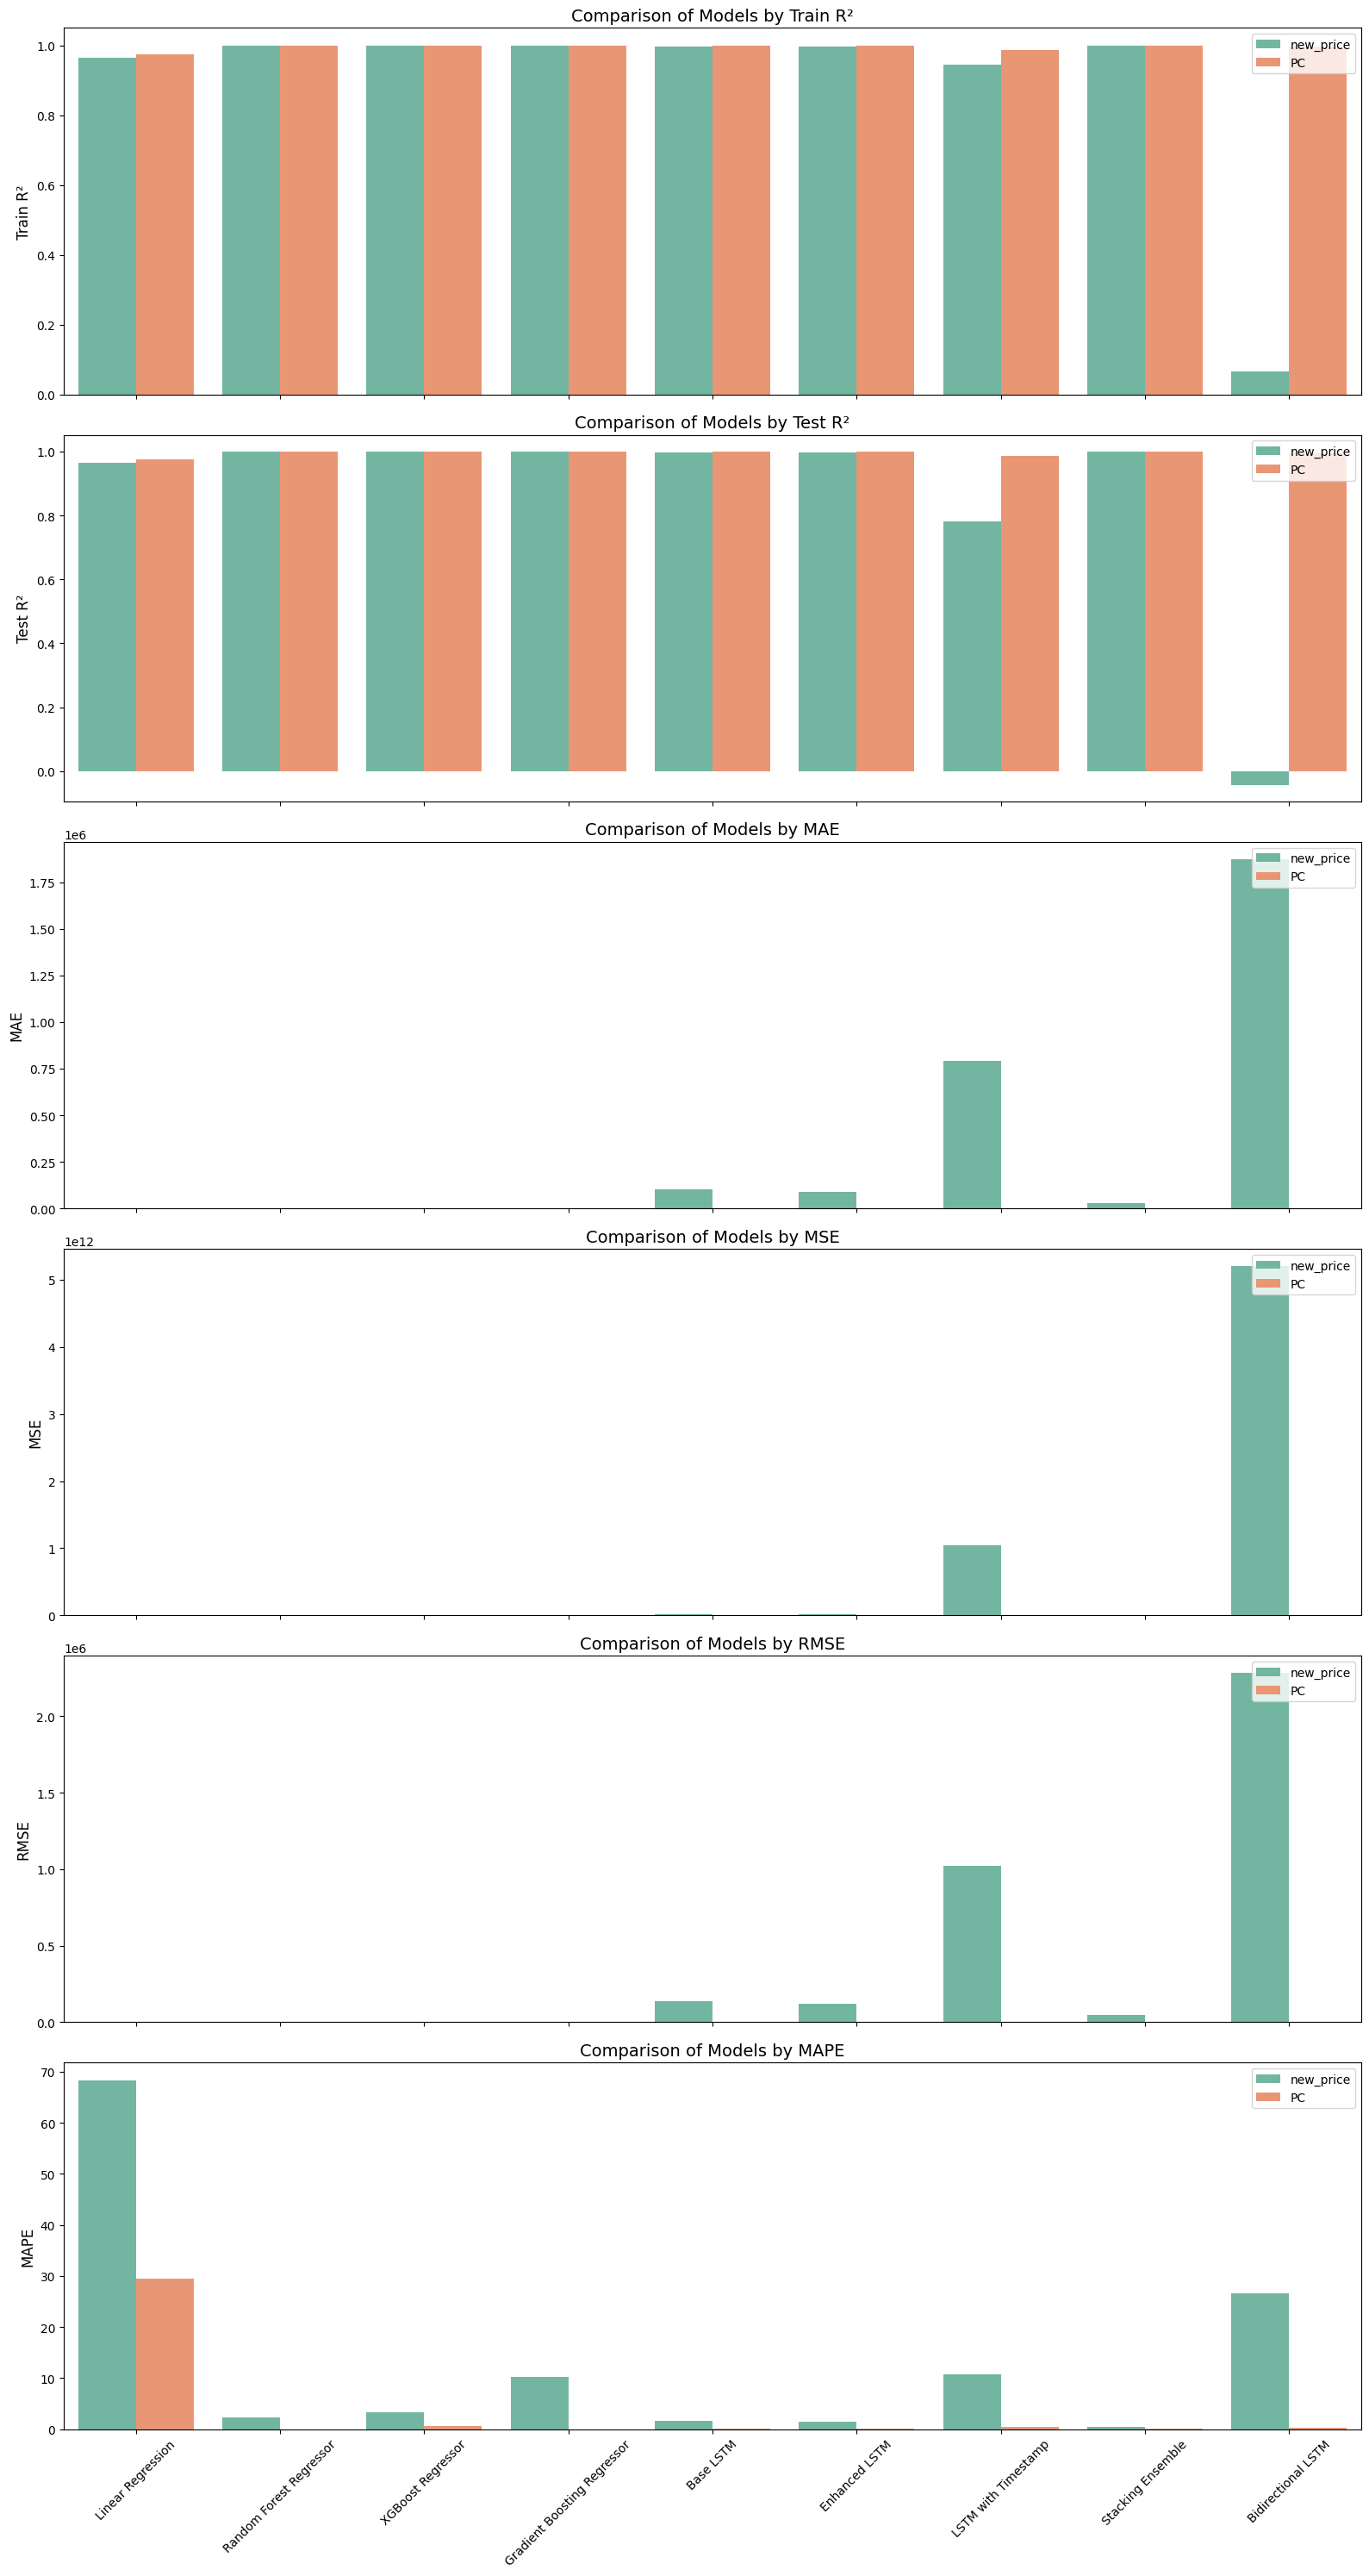

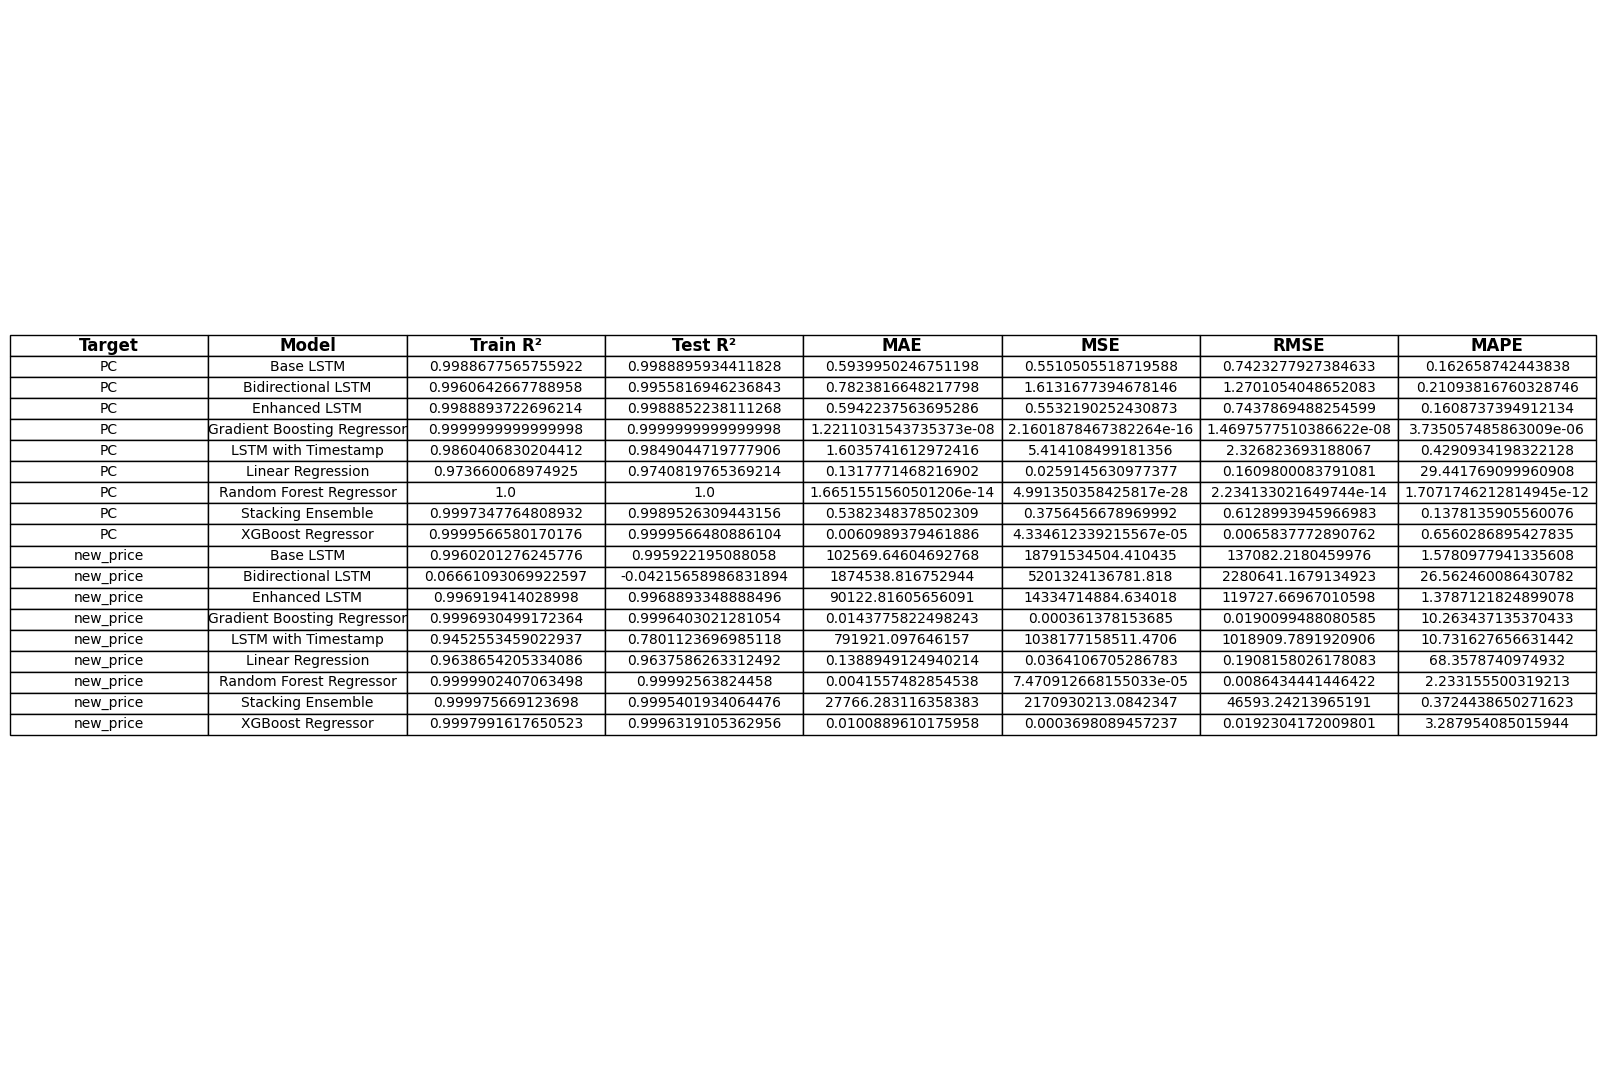

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot metrics
def plot_metrics(results_df, metrics):
    """
    Plot all metrics vertically on one page.

    :param results_df: DataFrame containing the evaluation results for models.
    :param metrics: List of metrics to plot.
    """
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 5 * num_metrics), sharex=True)

    # Plot each metric
    for i, metric in enumerate(metrics):
        sns.barplot(
            ax=axes[i],
            data=results_df,
            x="Model",
            y=metric,
            hue="Target",
            palette="Set2"
        )
        axes[i].set_title(f"Comparison of Models by {metric}", fontsize=14)
        axes[i].set_ylabel(metric, fontsize=12)
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].legend(fontsize=10, loc="upper right")

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Function to display results as a table
def display_results_table(results_df, metrics):
    """
    Display the results as a table on a separate page.

    :param results_df: DataFrame containing the evaluation results for models.
    :param metrics: List of metrics to include in the table.
    """
    # Extract relevant columns and sort
    table_data = results_df[["Target", "Model"] + metrics].sort_values(by=["Target", "Model"])

    # Display the table
    fig, ax = plt.subplots(figsize=(16, len(table_data) * 0.6))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        loc="center",
        cellLoc="center"
    )

    # Adjust font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Adjust column widths
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_fontsize(12)
            cell.set_text_props(weight="bold")
        cell.set_width(0.15)  # Adjust column width

    plt.tight_layout()
    plt.show()


# Ensure master_resultsStd exists
try:
    master_resultsStd
except NameError:
    raise ValueError("`master_resultsStd` is not defined. Please ensure it contains results for all models.")

# Define the list of metrics for plotting and table display
metrics_to_plot = ["Train R²", "Test R²", "MAE", "MSE", "RMSE", "MAPE"]

# Plot metrics vertically on one page
plot_metrics(master_resultsStd, metrics_to_plot)

# Display the results table on the next page
display_results_table(master_resultsStd, metrics_to_plot)

In [18]:
print(master_resultsStd.head(20))
print(master_resultsStd.shape)

       Target                        Model  Train R²   Test R²           MAE  \
0   new_price            Linear Regression  0.963865  0.963759  1.388949e-01   
1   new_price      Random Forest Regressor  0.999990  0.999926  4.155748e-03   
2   new_price            XGBoost Regressor  0.999799  0.999632  1.008896e-02   
3   new_price  Gradient Boosting Regressor  0.999693  0.999640  1.437758e-02   
4          PC            Linear Regression  0.973660  0.974082  1.317771e-01   
5          PC      Random Forest Regressor  1.000000  1.000000  1.665155e-14   
6          PC            XGBoost Regressor  0.999957  0.999957  6.098938e-03   
7          PC  Gradient Boosting Regressor  1.000000  1.000000  1.221103e-08   
8   new_price                    Base LSTM  0.996020  0.995922  1.025696e+05   
9          PC                    Base LSTM  0.998868  0.998890  5.939950e-01   
10  new_price                Enhanced LSTM  0.996919  0.996889  9.012282e+04   
11         PC                Enhanced LS